# Multi-Omics Measurements from Cancer Cells

This notebook explores the multi-omics dataset used in my thesis. The Cancer Cell Line Encyclopedia is a public repository of cell lines that are commonly used to study cancer biology. The whole dataset can be downloaded from the [CCLE website](https://sites.broadinstitute.org/ccle/).

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

## 1. Explaination

All of the **omics studies** are based on the same cancer cell samples from the 2019 version of the Cancer Cell Line Encyclopedia. The transciptomics data was obtained using **RNAseq next-level sequencing techniques**. Metabolomics measurements were added to the dataset in a repeated study using **liquid chromatography-mass spectrometry (LC-MS)**. MicroRNA levels were determinded using **quantitative RT-PCR (qPCR)**. All of the following analysis uses these three data types.

In [2]:
# load gene expression in reads per kilobase million (rpkm) values
genes = pd.read_csv('../data/CCLE2019/CCLE_RNAseq_genes_rpkm_20180929.gct', sep='\t')
# load metabolite levels from liquid chromatography-mass spectrometry (LC-MS)
metabolites = pd.read_csv('../data/CCLE2019/CCLE_metabolomics_20190502.csv')
# load microRNA expression levels from qPCR measurements
micrornas = pd.read_csv('../data/CCLE2019/CCLE_miRNA_20181103.gct', sep='\t')

## 2. Data Cleaning

We need to pick out the samples, where we have all of the omics information $X^{(v)}$ available. Otherwise, we cannot include them in the combined matrix $W$. Therefore, we search for the cell line ids and check if they are contained in the rows of the tables for all the data types.

In [3]:
cell_lines = pd.DataFrame(
    np.char.split(genes.columns[2:].tolist(), sep='_', maxsplit=1).tolist(),
    columns=["id","primary_site"])

# filter out cell lines that are not in all of the data frames below
cell_lines = cell_lines[(cell_lines.id + '_' + cell_lines.primary_site).isin(metabolites.CCLE_ID)]
cell_lines = cell_lines[(cell_lines.id + '_' + cell_lines.primary_site).isin(micrornas.columns)]

# The CCLE_ID is split into sample id and primary site
cell_lines['CCLE_ID'] = cell_lines.id + "_" + cell_lines.primary_site

Then we clean the data to have the same $(m \times n)$ tabular format, where the rows are the $m$ biological samples that we want to integrate and the columns are the $n$ features specific to the individual omics technology.

In [4]:
genes = genes[np.append((cell_lines.id + '_' + cell_lines.primary_site).values, 'Description')]
genes = genes.set_index('Description')
genes.index.names = ['Genes']
genes = genes.transpose().sort_index()
genes.index = genes.index.rename('CCLE_ID')

metabolites = metabolites.loc[metabolites['CCLE_ID'].isin((cell_lines.id + '_' + cell_lines.primary_site).values)]
metabolites = metabolites.sort_values('CCLE_ID')
metabolites = metabolites.set_index('CCLE_ID')
del metabolites['DepMap_ID']


micrornas = micrornas.drop(columns=['Name']).set_index('Description')
micrornas.index.names = ['miRNA']
micrornas = micrornas.transpose()
micrornas.index.names = ['CCLE_ID']
micrornas = micrornas.loc[(cell_lines.id + '_' + cell_lines.primary_site).values].sort_index()

## 3. Data Normalization

Perform **quantile normalization** on the gene expression dataset.

In [5]:
# gene view index
df = genes.transpose()

# aggregate duplicates
df = df.groupby(df.index).mean()

# quantile normalization
rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
df = df.rank(method='min').stack().astype(int).map(rank_mean).unstack()

# sample view index
genes = df.transpose()

## 4. Genetic Biomarkers

### 4.1 Doxorubicin on breast cancer (TOP2A)

From a [1997 study by Lynch \& Holden](https://pubmed.ncbi.nlm.nih.gov/9343325/) we know of a genetic biomarker in breast cancer and that the sensitivity of these cell lines to doxorubicin relate to expression of the target gene *TOP2A*.

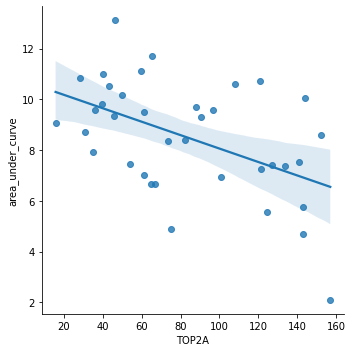

In [6]:
meta = pd.read_csv('../data/drugs.csv')
drug = meta[meta.cpd_name == 'doxorubicin']

df = drug.set_index(drug.ccl_name + '_' + drug.ccle_primary_site.str.upper())
df['TOP2A'] = genes['TOP2A'] # TOP2A DNA topoisomerase II alpha [ Homo sapiens (human) ]

sns.lmplot(x="TOP2A", y="area_under_curve", data=df[df.ccle_primary_site == "breast"])

In [7]:
data = df[df.ccle_primary_site == "breast"]

lin_model = sm.OLS(data.area_under_curve, data.TOP2A)
res = lin_model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       area_under_curve   R-squared (uncentered):                   0.661
Model:                            OLS   Adj. R-squared (uncentered):              0.651
Method:                 Least Squares   F-statistic:                              70.10
Date:                Sun, 08 May 2022   Prob (F-statistic):                    5.70e-10
Time:                        12:42:58   Log-Likelihood:                         -112.95
No. Observations:                  37   AIC:                                      227.9
Df Residuals:                      36   BIC:                                      229.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TOP2A          0.0773      0.009      8.373      0.000       0.059       0.096
==============================================================================
Omnibus:                        1.978   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                1.839
Skew:                          -0.503   Prob(JB):                        0.399
Kurtosis:                       2.574   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

"DNA topoisomerase II-alpha is the molecular target of doxorubicin, an active drug used in the therapy of breast cancer. From many in vitro studies, it is known that high levels of topo II-alpha expression correlate with drug sensitivity, and low levels of topo II-alpha correlate with drug resistance."

### 4.2 Dasatinib on non-small cell lung carcinoma (NSCLC)

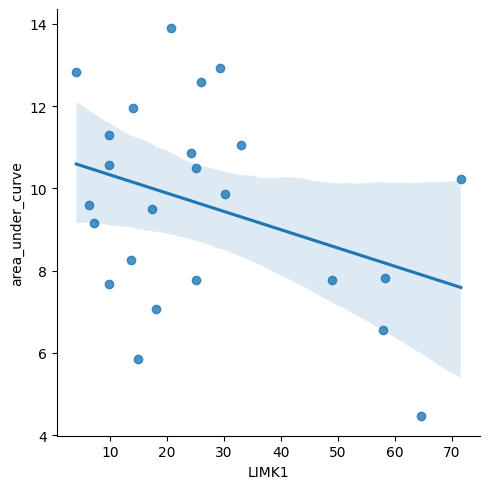

In [20]:
meta = pd.read_csv('../data/drugs.csv')
drug = meta[meta.cpd_name == 'dasatinib']

df = drug.set_index(drug.ccl_name + '_' + drug.ccle_primary_site.str.upper())
df['LIMK1'] = genes['LIMK1'] # LIMK1 LIM Domain Kinase 1 [ Homo sapiens (human) ]

sns.lmplot(x="LIMK1", y="area_under_curve", data=df[(df.ccle_primary_site == "lung") & ((df.ccle_hist_subtype_1 == "non_small_cell_carcinoma"))])

In [26]:
data = df[(df.ccle_primary_site == "lung") & (df.ccle_hist_subtype_1 == "non_small_cell_carcinoma")]
data = data.dropna()

lin_model = sm.OLS(data.area_under_curve, data.LIMK1)
res = lin_model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       area_under_curve   R-squared (uncentered):                   0.545
Model:                            OLS   Adj. R-squared (uncentered):              0.525
Method:                 Least Squares   F-statistic:                              27.50
Date:                Sun, 08 May 2022   Prob (F-statistic):                    2.55e-05
Time:                        14:21:33   Log-Likelihood:                         -79.578
No. Observations:                  24   AIC:                                      161.2
Df Residuals:                      23   BIC:                                      162.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LIMK1          0.2219      0.042      5.244      0.000       0.134       0.309
==============================================================================
Omnibus:                        4.588   Durbin-Watson:                   1.206
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                3.567
Skew:                          -0.944   Prob(JB):                        0.168
Kurtosis:                       2.949   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

https://www.frontiersin.org/articles/10.3389/fcell.2020.556532/full

"Altogether, we unveil that the inhibitory activities of dasatinib against lung cancer cells are realized by regulating LIMK1 activity directly and LIMK1/cofilin signaling pathway. [...] shows the prospective translational potential of dasatinib for patients with lung cancer who were accompanied with high expression of LIMK1"

## 5. Export Datasets

Export the cleaned multi-omics datasets. All tables need to have the same dimension $(m \times n)$ for graph-based data integration methods to work.

In [8]:
cell_lines.to_csv('../data/cells.csv', index=False)
genes.to_csv('../data/omics/genes.csv')
metabolites.to_csv('../data/omics/metabolites.csv')
micrornas.to_csv('../data/omics/mirnas.csv')